### Simulation parameters

In [1]:
import numpy as np

# hbar * c [GeV * fm]
hbarc = 0.197326 

# Simulation box 
L = 10      
N = 512 
tau_sim = 1    
DTS = 16

# Glasma
su_group = 'su3'
Qs = 2.0        
ns = 50    
factorqs = 0.8        
g2mu = Qs / factorqs   
g = np.pi * np.sqrt(1 / np.log(Qs / 0.2))          		
mu = g2mu / g**2      
factorm = 0.1    	
ir = factorm * g**2 * mu         
uv = 10.0           

### Environment variables

In [2]:
import os

# Comment this, I need it for JYU GPUs to choose a specific GPU to run on
os.environ["CUDA_VISIBLE_DEVICES"]="4"

os.environ["MY_NUMBA_TARGET"] = "cuda"
os.environ["PRECISION"] = "double"
os.environ["GAUGE_GROUP"] = su_group

# Import relevant modules
import sys
sys.path.append('..')

# Glasma modules
import curraun.core as core
import curraun.mv as mv
import curraun.initial as initial
initial.DEBUG = False

import curraun.su as su
from curraun.numba_target import use_cuda
if use_cuda:
    from numba import cuda

# Qhat module
import curraun.qhat as qhat

import pickle
from tqdm import tqdm

Using CUDA
Using SU(3)
Using double precision
Using double precision


### Run $\hat{q}$ module

In [3]:
def simulate_qhat(ev): 
    # Derived parameters
    a = L / N
    E0 = N / L * hbarc
    DT = 1.0 / DTS
    maxt = int(tau_sim / a * DTS)

    # Initialize Glasma fields
    s = core.Simulation(N, DT, g)
    va = mv.wilson(s, mu=mu / E0, m=ir / E0, uv=uv / E0, num_sheets=ns)
    vb = mv.wilson(s, mu=mu / E0, m=ir / E0, uv=uv / E0, num_sheets=ns)
    initial.init(s, va, vb)

    # Initialize the Qhat module
    qhat_tforce = qhat.TransportedForce(s)
    mom_broad, xplus =  [], []

    if use_cuda:
        qhat_tforce.copy_to_device()

    with tqdm(total=maxt) as pbar:
        for t in range(maxt):
            # Compute momentum broadening from Qhat module
            if t % DTS == 0:
                if use_cuda:
                    qhat_tforce.copy_mean_to_host()

                # Units GeV^2
                mom_broad.append(qhat_tforce.p_perp_mean * E0 ** 2)
                # Units GeV^-1
                xplus.append(t*a/DTS/hbarc)
                
                if use_cuda:
                    qhat_tforce.copy_mean_to_device()
            qhat_tforce.compute()

            # Evolve Glasma fields
            core.evolve_leapfrog(s)

            pbar.set_description("Event " + str(ev+1))
            pbar.update(1)

    return mom_broad, xplus

### Run multiple Glasma events, do averages

In [4]:
nevents = 5

mom_broads = []
for ev in range(nevents):
    mom_broad_ev, xplus = simulate_qhat(ev)
    mom_broads.append(mom_broad_ev)

mom_broad = np.mean(mom_broads, axis=0)

Event 5: 100%|██████████| 819/819 [01:52<00:00,  7.30it/s]


### Plot $\delta p^2$ and $\hat{q}$

In [5]:
import matplotlib.pyplot as plt

from matplotlib import rc
# rc('text', usetex=True)
plt.rcParams["figure.figsize"] = (7, 6)
plt.rcParams.update({'font.size':18})

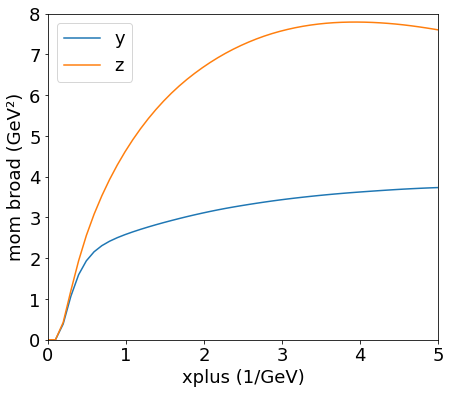

In [8]:
labels = ["x", "y", "z"]

# for i in range(3):
for i in [1,2]:
    plt.plot(xplus, mom_broad[:, i], label=labels[i])

# plt.plot(xplus, mom_broad[:, 1] + mom_broad[:, 2], label="y+z")

plt.xlabel("xplus (1/GeV)")
plt.ylabel("mom broad (GeV²)")
plt.xlim([0, 5])
plt.ylim([0, 8])
plt.legend()
plt.show()

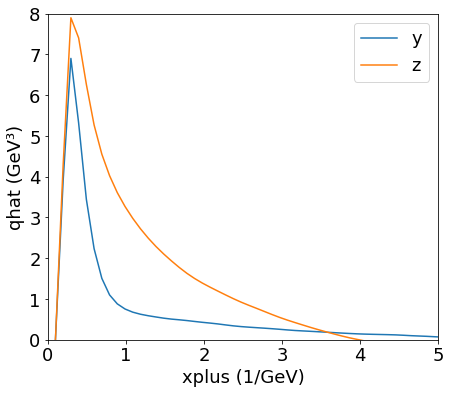

In [9]:
labels = ["x", "y", "z"]

# for i in range(3):
for i in [1,2]:
    qhat = np.diff(mom_broad[:, i]) / np.diff(xplus)
    plt.plot(xplus[1:len(xplus)], qhat, label=labels[i])

plt.xlabel("xplus (1/GeV)")
plt.ylabel("qhat (GeV³)")
plt.xlim([0, 5])
plt.ylim([0, 8])
plt.legend()
plt.show()